CIFAR 100 Baseline with Data Augmentation (Yash)

## Import the required Libraries

In [1]:
# Goal: 72% Validation Accuracy
# (Compare data augmentation vs no data augmentation)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from PIL import Image
# from skimage import io, transform
# import os
# from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
# from collections import Counter
# from google.colab import drive
# from prophet import Prophet
# from statsmodels.tsa.arima.model import ARIMA
# !pip install -U pandasql
# import pandasql as ps

## Set up GPU capabilities (1 point)

The cell below sets up a CUDA device to use with torch, if available to you.

**Remeber to turn on the GPU for runtime in Colab**
*   Go to Runtime -> Change runtime type --> GPU


Note that you can create a PyTorch tensor `T` that resides on the GPU using the command `T = torch.Tensor(..., device=cuda)`.
You can also copy existing tensors to the GPU with the command `T = T.to(device)` (make sure to overwrite `T` with the result of this function call). If you do not have a GPU, these commands will still work.

**NOTE**: The grader cell below is to check that you are using the GPU, since it is beneficial in later sections that require parallel computation on arrays (i.e., Section 2).

In [2]:
# DO NOT MODIFY
torch.manual_seed(42) # For grading consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.1.0
cuda:0


In [3]:
device

device(type='cuda', index=0)

### 1.1.1 Instantiate Dataset (for train/test dataset) (4 points)

One optional function in Dataset class is `transform`, where we can apply a transformation to the dataset before we load them as a dataloader.

For example if we define a `Resize` function in transform, all of our dataset(images) would be resized to specified size passed in as an argument.

---
**TODO**: complete the code to apply following transformations (in order!!) by using `transforms.Compose` and save it to the variable `transform`:

1.   Resize the image to 32 by 32 $\to$ just to make sure they are really have size $32$x$32$
2.   Convert the images to Tensor
3.   Normalize the Tensor using, the means `[0.485, 0.456, 0.406]` and standard deviations `[0.229, 0.224, 0.225]`. We do this because these are color images, and so there are **three** color channels for which we need to normalize (r, g, b).
---
**Reccomandations**:

1. We highly recommend looking at [PyTorch documentation](https://pytorch.org/vision/stable/transforms.html) and some [illustrations](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) before proceeding with the code

2. Please review the the recitation notebook for detailed instructions on how to perform these operations.

3. You might be asking, why we are using these two lists `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]` to normalize the tensor? These two lists are the mean and the standard deviation of each dimension in the [ImageNet](https://www.image-net.org/index.php) dataset respectively. ImageNet has a total of 14,197,122 Images, so it makes sense to use these values for the respective RGB channels, especially since we are working with color images.

In [8]:
scale = 32
train_transform_no_aug = transforms.Compose([
    transforms.Resize((scale,scale)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomCrop(scale, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_transform_aug = transforms.Compose([
    transforms.Resize((scale,scale)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(scale, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


test_transform = transforms.Compose([
    transforms.Resize((scale,scale)),
    transforms.
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


In [9]:
# Create Dataloaders
train_dataset_aug = torchvision.datasets.CIFAR100(root = './data', train = True, download = True, transform = train_transform_aug)
train_dataset_no_aug = torchvision.datasets.CIFAR100(root = './data', train = True, download = True, transform = train_transform_no_aug)
test_dataset = torchvision.datasets.CIFAR100(root = './data', train = False, download = True, transform = test_transform)
train_subset_aug = torch.utils.data.Subset(train_dataset_aug, [i for i in range(len(train_dataset_aug)) if i % 1 ==0])
train_subset_no_aug = torch.utils.data.Subset(train_dataset_no_aug, [i for i in range(len(train_dataset_no_aug)) if i % 1 ==0])

test_subset = torch.utils.data.Subset(test_dataset, [i for i in range(len(test_dataset)) if i % 1 ==0])
batch = 64
train_loader_aug = DataLoader(train_subset_aug, batch_size = batch, shuffle = True, num_workers = 0)
train_loader_no_aug = DataLoader(train_subset_no_aug, batch_size = batch, shuffle = True, num_workers = 0)

test_loader = DataLoader(test_subset, batch_size = batch, shuffle = True, num_workers = 0)
# TODO END

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## ImageNet

In [4]:
!pip install datasets

In [4]:
from datasets import *
from collections import Counter
tiny_imagenet_train = load_dataset('Maysee/tiny-imagenet', split='train')
tiny_imagenet_valid = load_dataset('Maysee/tiny-imagenet', split='valid')
tiny_imagenet_train = tiny_imagenet_train.filter(lambda x: np.array(x['image']).shape == (64,64,3))
tiny_imagenet_valid = tiny_imagenet_valid.filter(lambda x: np.array(x['image']).shape == (64,64,3))

In [5]:
tiny_imagenet_train.set_format(type='torch', columns=['image', 'label'])
tiny_imagenet_valid.set_format(type='torch', columns=['image', 'label'])
tiny_imagenet_train = tiny_imagenet_train.with_format('torch', device=device, dtype=torch.float32)
tiny_imagenet_valid = tiny_imagenet_valid.with_format('torch', device=device, dtype=torch.float32)


In [6]:
batch = 64
# TODO
train_loader = DataLoader(tiny_imagenet_train, batch_size = batch, shuffle = True, num_workers = 0)
test_loader = DataLoader(tiny_imagenet_valid, batch_size = batch, shuffle = True, num_workers = 0)

In [7]:
# TODO: create subsets of the training and testing data
train_subset = torch.utils.data.Subset(tiny_imagenet_train, [i for i in range(len(tiny_imagenet_train)) if i % 1 ==0])
test_subset = torch.utils.data.Subset(tiny_imagenet_valid, [i for i in range(len(tiny_imagenet_valid)) if i % 1 ==0])
# End TODO

In [8]:
train_subset.dataset.transform = train_transform
test_subset.dataset.transform = test_transform

In [9]:
train_subset[0]#['image'].double()

{'image': tensor([[[255., 136., 193.],
          [255., 138., 192.],
          [249., 146., 199.],
          ...,
          [208., 237., 235.],
          [209., 241., 240.],
          [127., 163., 161.]],
 
         [[255., 126., 189.],
          [254., 128., 189.],
          [246., 137., 194.],
          ...,
          [205., 231., 230.],
          [202., 234., 231.],
          [123., 159., 155.]],
 
         [[255., 126., 201.],
          [255., 129., 201.],
          [255., 135., 203.],
          ...,
          [207., 233., 230.],
          [202., 234., 229.],
          [120., 155., 149.]],
 
         ...,
 
         [[ 95., 122.,  71.],
          [ 93., 119.,  71.],
          [ 93., 116.,  70.],
          ...,
          [ 85.,  74.,  56.],
          [ 78.,  67.,  49.],
          [ 94.,  83.,  65.]],
 
         [[ 89., 117.,  66.],
          [ 89., 115.,  67.],
          [ 89., 112.,  66.],
          ...,
          [ 86.,  75.,  57.],
          [ 77.,  66.,  48.],
          [ 87.,  

Now that we have `train_subset` and `test_subset`, let's create dataloaders using these two datasets.

You can load the dataset into dataloaders using the `DataLoaders` object. Please refer to the documentation [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

---
**TODO**:
* Initialize the `DataLoader` object for `train_subset` as `train_loader`
* Initialize the `DataLoader` object for `test_subset` as `test_loader`
---

**NOTE**: set the `batch_size` equal to the previously-defined variable `batch`, set `shuffle` to `True`, and `num_workers` as 0.


In [10]:
batch = 64
# TODO
train_loader = DataLoader(train_subset, batch_size = batch, shuffle = True, num_workers = 0)
test_loader = DataLoader(test_subset, batch_size = batch, shuffle = True, num_workers = 0)
# TODO END

In [356]:
for i, x in enumerate(train_loader):
    print(x['image'].permute(0,3,1,2).shape)

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 6

KeyboardInterrupt: 

In [ ]:
class CNN_best_Imagenet(nn.Module):
    def __init__(self):
        super().__init__()
        # Make sure to have ReLU BEFORE BatchNorm, not other way around

        self.conv1 = nn.Conv2d(in_channels= 3, out_channels = 256, kernel_size=3, stride=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(in_channels= 256, out_channels = 256, kernel_size=3, stride=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(256)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(in_channels= 256, out_channels = 512, kernel_size=3, stride=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(in_channels= 512, out_channels = 512, kernel_size=3, stride=1)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(512)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.2)

        self.block = nn.Sequential(
          nn.Conv2d(in_channels= 512, out_channels = 512, kernel_size=2, stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.Conv2d(in_channels= 512, out_channels = 512, kernel_size=2, stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(kernel_size=2),
          nn.Dropout(0.2)
        )


        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features= 512, out_features= 300)
        self.fc2 = nn.Linear(in_features= 300, out_features=200)

        # END TODO

    def forward(self, x):
        # TODO
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.bn3(x)

        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        for i in range(2):
          x = self.block(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        # END TODO
        return x



In [ ]:
def train_imagenet(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0
        if epoch > 0 and epoch % 25 == 0:
          for op_params in optimizer.param_groups:
            op_params['lr'] = op_params['lr'] * 0.1
        for i, x in enumerate(train_loader):
            # Move tensors to configured device
            images = x['image'].permute(0,3,1,2)
          #  print(images.shape)
            labels = x['label']
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }


        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, x in enumerate(test_loader):
                images = x['image'].permute(0,3,1,2)
                labels = x['label']
                labels = labels.type(torch.LongTensor)
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss)
    return val_error,val_loss_values,train_error,train_loss_values

## Modeling

In [52]:
class CNN_best(nn.Module):
    def __init__(self):
        super().__init__()
        # Make sure to have ReLU BEFORE BatchNorm, not other way around

        self.conv1 = nn.Conv2d(in_channels= 3, out_channels = 64, kernel_size=3, stride=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels= 64, out_channels = 128, kernel_size=3, stride=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(128)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(in_channels= 128, out_channels = 256, kernel_size=3, stride=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels= 256, out_channels = 512, kernel_size=3, stride=1)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(512)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.2)

        self.block = nn.Sequential(
          nn.Conv2d(in_channels= 512, out_channels = 512, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.Conv2d(in_channels= 512, out_channels = 512, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
        #  nn.MaxPool2d(kernel_size=2),
        #  nn.Dropout(0.2)
        )


        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features= 512, out_features= 128)
        self.fc2 = nn.Linear(in_features= 128, out_features=100)
        self.softmax = nn.Softmax()

        # END TODO

    def forward(self, x):
        # TODO
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.bn4(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        for i in range(1):
          x = self.block(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = CNN_best()


In [47]:
# Training loop
def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        running_loss = 0.0
        if epoch > 0 and epoch % 25 == 0:
          for op_params in optimizer.param_groups:
            op_params['lr'] = op_params['lr'] * 0.1
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }


        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss)
    return val_error,val_loss_values,train_error,train_loss_values

In [7]:
# ResNet34 model to compare with
resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
# Hyperparameters
momentum = 0.9
weight_decay = 0 # 1e-5
resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model = CNN_best().to(device) # or resnet
criterion = nn.CrossEntropyLoss()
# END TODO
optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.99,0.999)) #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)

epochs = 100

val_error_res_no_aug,val_loss_values_res_no_aug,train_error_res_no_aug,train_loss_values_res_no_aug= train(model, optimizer, criterion, train_loader_no_aug, test_loader, epochs, 'cnn_curve', True) # also check train_loader_aug

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy of the network on the test images: 27.69 %
Accuracy of the network on the test images: 37.8 %
Accuracy of the network on the test images: 42.81 %
Accuracy of the network on the test images: 46.35 %
Accuracy of the network on the test images: 48.66 %
Accuracy of the network on the test images: 50.75 %
Accuracy of the network on the test images: 49.33 %
Accuracy of the network on the test images: 48.71 %
Accuracy of the network on the test images: 48.33 %
Accuracy of the network on the test images: 48.3 %
Accuracy of the network on the test images: 48.26 %
Accuracy of the network on the test images: 48.66 %
Accuracy of the network on the test images: 48.55 %
Accuracy of the network on the test images: 48.56 %
Accuracy of the network on the test images: 48.61 %
Accuracy of the network on the test images: 47.96 %
Accuracy of the network on the test images: 49.14 %
Accuracy of the network on the test images: 47.53 %
Accuracy of the network on the test images: 46.95 %
Accuracy of th

In [54]:
val_error_res_no_aug,val_loss_values_res_no_aug,train_error_res_no_aug,train_loss_values_res_no_aug

([72.31,
  62.2,
  57.19,
  53.65,
  51.34,
  49.25,
  50.67,
  51.29,
  51.67,
  51.7,
  51.74,
  51.34,
  51.45,
  51.44,
  51.39,
  52.04,
  50.86,
  52.47,
  53.05,
  52.28,
  52.22,
  52.13,
  52.11,
  51.33,
  51.67,
  49.61,
  49.26,
  49.15,
  49.1,
  49.02,
  48.85,
  48.76,
  48.81,
  48.45,
  48.72,
  48.69,
  48.48,
  48.54,
  48.0,
  47.92,
  48.11,
  48.49,
  48.22,
  48.44,
  48.27,
  48.29,
  48.08,
  48.0,
  48.07,
  49.18,
  48.25,
  48.08,
  47.93,
  48.04,
  47.93,
  47.93,
  47.8,
  47.74,
  47.78,
  47.75,
  47.6,
  47.6,
  47.49,
  47.57,
  47.61,
  47.45,
  47.48,
  47.38,
  47.44,
  47.41,
  47.38,
  47.38,
  47.45,
  47.4,
  47.4,
  47.4,
  47.41,
  47.41,
  47.4,
  47.42,
  47.4,
  47.4,
  47.41,
  47.4,
  47.4,
  47.4,
  47.39,
  47.39,
  47.39,
  47.38,
  47.38,
  47.37,
  47.37,
  47.37,
  47.38,
  47.39,
  47.38,
  47.38,
  47.38,
  47.37],
 [2758.4879558086395,
  2075.545050263405,
  1698.5487489700317,
  1402.076287150383,
  1105.1124871373177,
  819.54

In [55]:
# Identify best learning rate
lr = 1e-5  # init eta
model = CNN_best().to(device)
epochs = 50
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.99,0.999))

t = 0 # number of updates
flag = True # for loop exiting purposes

lr_list = []
train_loss_list = []
avg_loss_list = []

model.train()
for epoch in range(epochs):
    print(epoch)
    if flag:
        for batch_idx, (images, labels) in enumerate(train_loader_aug):
            if t == 100:
                flag = False
                break

            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()

            train_loss_list.append(loss.item())

            if (batch_idx + (epoch * 391) + 1) % 100 == 0:
                # update the learning rate
                lr *= 1.1
                lr_list.append(lr)

                avg_loss = np.mean(train_loss_list)
                avg_loss_list.append(avg_loss)

                train_loss_list = []

                # update lr in optimizer
                optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.99,0.999))
                optimizer.step()

                t+=1
    else:
        break
print("Training Finished")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
Training Finished


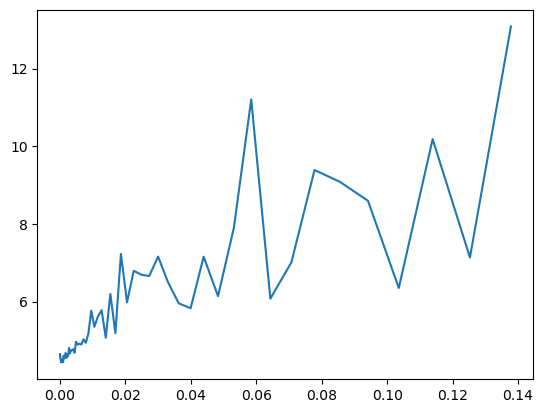

In [56]:
plt.plot(lr_list,avg_loss_list)

In [20]:
val_error_res_aug,val_loss_values_res_aug,train_error_res_aug,train_loss_values_res_aug

([99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93,
  99.93],
 [10310.550107955933,
  10825.206008911133,
  10840.925400733948,
  10822.91562461853,
  10843.3362

In [21]:
val_error_res_no_aug,val_loss_values_res_no_aug,train_error_res_no_aug,train_loss_values_res_no_aug

([56.08,
  51.01,
  47.73,
  46.51,
  45.26,
  47.16,
  45.11,
  45.3,
  45.74,
  45.68,
  45.75,
  46.5,
  46.06,
  45.94,
  46.59,
  45.22,
  46.47,
  47.02,
  45.88,
  46.05,
  45.76,
  45.51,
  46.0,
  46.79,
  46.59,
  43.4,
  43.0,
  42.95,
  43.1,
  42.65,
  42.54,
  42.74,
  42.4,
  42.54,
  42.46,
  42.17,
  42.14,
  42.22,
  42.39,
  42.27,
  42.92,
  42.42,
  42.02,
  41.97,
  42.35,
  42.23,
  42.33,
  42.07,
  42.21,
  42.84,
  42.4,
  42.35,
  42.34,
  42.24,
  42.24,
  42.27,
  42.22,
  42.2,
  42.3,
  42.2,
  42.2,
  42.14,
  42.2,
  42.27,
  42.12,
  42.2,
  42.1,
  42.16,
  42.22,
  42.22,
  42.33,
  42.0,
  42.15,
  42.16,
  42.13,
  42.11,
  42.13,
  42.14,
  42.15,
  42.14,
  42.15,
  42.18,
  42.16,
  42.17,
  42.19,
  42.16,
  42.17,
  42.17,
  42.18,
  42.17,
  42.18,
  42.19,
  42.15,
  42.14,
  42.12,
  42.14,
  42.14,
  42.14,
  42.13,
  42.1],
 [2385.5635056495667,
  1518.3009963035583,
  1175.0639261603355,
  944.6377992033958,
  735.3003966808319,
  579.74

In [29]:
lr = 1e-4
momentum = 0.9
weight_decay = 0 # 1e-5

model = CNN_best().to(device)
criterion = nn.CrossEntropyLoss()
# END TODO
optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.9,0.999)) #lr - learning step
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)
epochs = 10


val_error_noaug,val_loss_values_noaug,train_error_noaug,train_loss_values_noaug= train(model, optimizer, criterion, train_loader, test_loader, epochs, 'cnn_curve', True)

Accuracy of the network on the test images: 35.09 %
Accuracy of the network on the test images: 44.31 %
Accuracy of the network on the test images: 49.07 %
Accuracy of the network on the test images: 51.96 %
Accuracy of the network on the test images: 51.85 %
Accuracy of the network on the test images: 50.63 %
Accuracy of the network on the test images: 50.12 %
Accuracy of the network on the test images: 50.67 %
Accuracy of the network on the test images: 50.06 %
Accuracy of the network on the test images: 49.64 %


In [76]:
lr = 1e-3
momentum = 0.9
weight_decay = 0 # 1e-5

model = CNN_best().to(device)
criterion = nn.CrossEntropyLoss()
# END TODO
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9,0.999)) #lr - learning step
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)

epochs = 100


val_error_bestcnn,val_loss_values_bestcnn,train_error_bestcnn,train_loss_values_bestcnn= train(model, optimizer, criterion, train_loader, test_loader, epochs, 'cnn_curve', True)

Accuracy of the network on the test images: 28.01 %
Accuracy of the network on the test images: 38.31 %
Accuracy of the network on the test images: 45.39 %
Accuracy of the network on the test images: 51.0 %
Accuracy of the network on the test images: 53.41 %
Accuracy of the network on the test images: 55.45 %
Accuracy of the network on the test images: 56.7 %
Accuracy of the network on the test images: 57.82 %
Accuracy of the network on the test images: 58.82 %
Accuracy of the network on the test images: 59.52 %
Accuracy of the network on the test images: 59.22 %
Accuracy of the network on the test images: 60.72 %
Accuracy of the network on the test images: 60.6 %
Accuracy of the network on the test images: 60.81 %
Accuracy of the network on the test images: 61.19 %
Accuracy of the network on the test images: 61.56 %
Accuracy of the network on the test images: 61.12 %
Accuracy of the network on the test images: 61.4 %
Accuracy of the network on the test images: 61.12 %
Accuracy of the 

In [67]:
lr = 1e-3
momentum = 0.9
weight_decay = 0 # 1e-5

model = resnet34.to(device)
criterion = nn.CrossEntropyLoss()
# END TODO
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9,0.99)) #lr - learning step
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)

epochs = 100


val_error_resnet,val_loss_values_resnet,train_error_resnet,train_loss_values_resnet= train(model, optimizer, criterion, train_loader, test_loader, epochs, 'cnn_curve', True)

Accuracy of the network on the test images: 36.97 %
Accuracy of the network on the test images: 43.85 %
Accuracy of the network on the test images: 48.01 %
Accuracy of the network on the test images: 50.58 %
Accuracy of the network on the test images: 51.82 %
Accuracy of the network on the test images: 54.06 %
Accuracy of the network on the test images: 53.73 %
Accuracy of the network on the test images: 56.26 %
Accuracy of the network on the test images: 56.64 %
Accuracy of the network on the test images: 56.33 %
Accuracy of the network on the test images: 57.31 %
Accuracy of the network on the test images: 57.46 %
Accuracy of the network on the test images: 56.2 %
Accuracy of the network on the test images: 56.9 %
Accuracy of the network on the test images: 55.91 %
Accuracy of the network on the test images: 57.89 %
Accuracy of the network on the test images: 56.67 %
Accuracy of the network on the test images: 57.93 %
Accuracy of the network on the test images: 57.54 %
Accuracy of th

In [43]:
#val_error_relu_first,val_loss_values_relu_first,train_error_relu_first,train_loss_values_relu_first = val_error,val_loss_values,train_error,train_loss_values

In [56]:
val_error_relu_first,val_loss_values_relu_first,train_error_relu_first,train_loss_values_relu_first

([74.12,
  63.55,
  56.97,
  52.08,
  48.86,
  47.81,
  46.04,
  44.03,
  42.93,
  41.53,
  41.45,
  40.52,
  40.23,
  39.91,
  39.71,
  39.23,
  39.61,
  39.06,
  38.73,
  38.83,
  39.47,
  39.05,
  38.94,
  38.92,
  38.05,
  36.0,
  35.78,
  35.64,
  35.47,
  35.3,
  35.06999999999999,
  35.28,
  35.09,
  35.269999999999996,
  35.230000000000004,
  35.18000000000001,
  35.08,
  35.22,
  35.05,
  35.41,
  35.31,
  35.120000000000005,
  35.28,
  35.269999999999996,
  35.16,
  35.08,
  34.92,
  35.099999999999994,
  35.120000000000005,
  35.120000000000005,
  35.28,
  35.150000000000006,
  35.31999999999999,
  35.31999999999999,
  35.209999999999994,
  35.260000000000005,
  35.06999999999999,
  35.06,
  35.61,
  35.41,
  35.64,
  35.480000000000004,
  35.5,
  35.28,
  35.17,
  35.010000000000005,
  35.239999999999995,
  35.290000000000006,
  35.370000000000005,
  35.22,
  35.45,
  35.39,
  35.5,
  35.099999999999994,
  35.14,
  35.16,
  35.22,
  35.42,
  35.18000000000001,
  35.3,
  35.

In [33]:
val_error_bn_first,val_loss_values_bn_first,train_error_bn_first,train_loss_values_bn_first = val_error,val_loss_values,train_error,train_loss_values

## Results

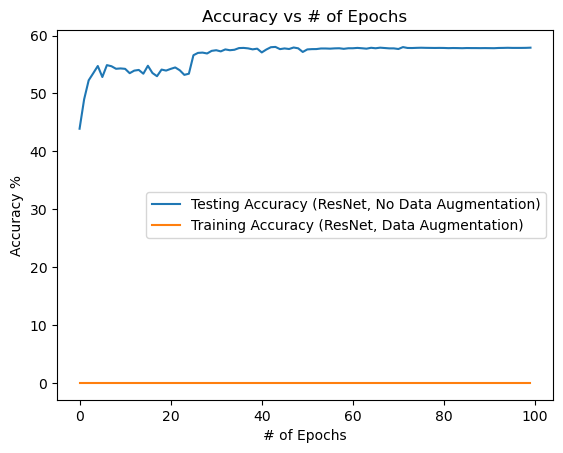

In [22]:
# Plotting results
plt.plot([100 - x for x in val_error_res_no_aug],label = "Testing Accuracy (ResNet, No Data Augmentation)")
plt.plot([100 - x for x in val_error_res_aug],label="Training Accuracy (ResNet, Data Augmentation)")
# plt.plot([100 - x for x in val_error_noaug],label = "Testing Accuracy (CNN, No Data Augmentation)")
# plt.plot([100 - x for x in train_error_noaug],label="Training Accuracy (CNN, No Data Augmentation)")

plt.xlabel("# of Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy vs # of Epochs")
plt.legend()

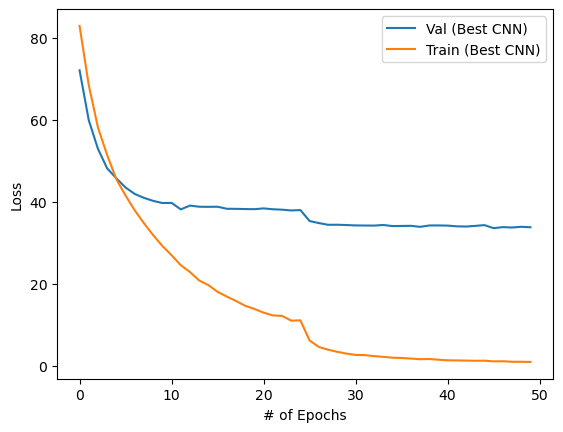

In [22]:
plt.plot(val_error_imagenet,label = "Val (Best CNN)")
#plt.plot(train_loss_values_bestcnn,label="Training Error (Best CNN)")
plt.plot(train_error_imagenet,label = "Train (Best CNN)")
# plt.plot(train_loss_values_resnet,label="Training Error (Resnet)")
plt.xlabel("# of Epochs")
plt.ylabel("Loss")
plt.legend()